# Endpoint Performance: Endpoint Peering

The goal of this experiment is to understand the latency and bandwidth between endpoints issuing requests to peer endpoints.
We compare to using a Redis server with SSH tunnels as an alternative.

## Instructions

### Setup

1. Clone and install https://github.com/proxystore/proxystore-benchmarks
   ```bash
   $ git clone git@github.com:proxystore/proxystore-benchmarks.git
   $ cd proxystore-benchmarks
   $ virtualenv venv
   $ . venv/bin/activate
   $ pip install -e .
   ```
2. Configure a ProxyStore endpoint on the local and remote systems.
   ```bash
   $ proxystore-endpoint configure psbench
   $ proxystore-endpoint start psbench
   ```
   Note: endpoint logs will be written to `~/.local/share/proxystore/psbench/`, and the endpoints should be stopped after testing.
   
### Run

```bash
$ python -m psbench.benchmarks.remote_ops \
      REDIS \
      --redis-host thetalogin5 \
      --redis-port 59465 \
      --ops GET SET EXISTS EVICT \
      --payload-sizes 1000 10000 100000 1000000 10000000 \
      --repeat 10 \
      --csv-file results/thetalogin4-thetalogin5-remote-ops.csv
      
$ python -m psbench.benchmarks.remote_ops \
      ENDPOINT \
      --endpoint {ENDPOINT UUID} \
      --server {SIGNALING SERVER URL } \
      --ops GET SET EXISTS EVICT \
      --payload-sizes 1000 10000 100000 1000000 10000000 \
      --repeat 10 \
      --csv-file results/thetalogin4-thetalogin5-remote-ops.csv
```

### Notes:
- In all cases we used two peer channels for the endpoints.

In [28]:
%matplotlib inline

from __future__ import annotations

import math
from typing import Any

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.markers as markers
import pandas
import numpy

In [29]:
ENDPOINTS_NAME = 'PX-Endpoints'
BACKEND_COLUMN = 'backend'
OP_COLUMN = 'op'
PAYLOAD_COLUMN = 'payload_size_bytes'
AVG_TIME_COLUMN = 'avg_time_ms'
MIN_TIME_COLUMN = 'min_time_ms'
MAX_TIME_COLUMN = 'max_time_ms'
STDEV_TIME_COLUMN = 'stdev_time_ms'

def load(filepath: str) -> pandas.DataFrame:
    return pandas.read_csv(filepath)

In [30]:
theta_data = load('data/4-endpoint-performance-peering/thetalogin4-thetalogin5-remote-ops.csv')
midway_data = load('data/4-endpoint-performance-peering/midway2-thetalogin5-remote-ops.csv')
frontera_data = load('data/4-endpoint-performance-peering/frontera-thetalogin5-remote-ops.csv')
frontera_data

,backend,op,payload_size_bytes,repeat,total_time_ms,avg_time_ms,min_time_ms,max_time_ms,stdev_time_ms,avg_bandwidth_mbps
0,ENDPOINT,EXISTS,NaN,10,293.490508,36.686313,36.539859,36.799613,0.105508,NaN
1,ENDPOINT,EVICT,NaN,10,294.102830,36.762854,36.563746,37.450162,0.326391,NaN
2,ENDPOINT,GET,1000.0,25,852.185747,37.051554,36.533593,44.334380,1.592366,0.026989
3,ENDPOINT,GET,10000.0,25,1689.201073,73.443525,72.858307,79.495667,1.330832,0.136159
4,ENDPOINT,GET,100000.0,10,972.002029,121.500254,112.111567,147.611303,15.856796,0.823044
5,ENDPOINT,GET,1000000.0,10,1802.129825,225.266228,219.715603,230.823866,3.370814,4.439192
6,ENDPOINT,GET,10000000.0,10,8989.255362,1123.656920,917.851381,1453.890219,194.351811,8.899514
7,ENDPOINT,SET,1000.0,10,293.839506,36.729938,36.623479,36.965751,0.101989,0.027226
8,ENDPOINT,SET,10000.0,10,752.790208,94.098776,73.222121,238.275425,58.256597,0.106271
9,ENDPOINT,SET,100000.0,10,913.037655,114.129707,113.334567,116.436480,1.102015,0.876196


In [31]:
def rows_matching_column_value(data: pandas.DataFrame, column: str, value) -> pandas.DataFrame:
    return data.loc[data[column] == value]

def get_value_by_other_column(data: pandas.DataFrame, query_column: str, query_value: Any, target_column: str) -> Any:
    rows = data.loc[data[query_column] == query_value]
    assert len(rows) == 1
    return rows[target_column].values[0]

In [32]:
DATA = {
    'Theta → Theta': theta_data,
    'Campus Cluster → Theta': midway_data,
    'Frontera → Theta': frontera_data,
}
F_STR = '{system:22} | {op:6} | {size:<9} | {avg_endpoint:8.3f} | {avg_redis:8.3f}'

print('                                |  Payload  |  Avg Op Time (ms)')
print('Systems                | Op     |   Bytes   | Endpoint |  Redis')

for systems, data in DATA.items():
    print('-----------------------|--------|-----------|----------|---------')
    for op in ['GET', 'SET', 'EVICT', 'EXISTS']:
        op_data = rows_matching_column_value(data, OP_COLUMN, op)
        endpoint_data = rows_matching_column_value(op_data, BACKEND_COLUMN, 'ENDPOINT')
        redis_data = rows_matching_column_value(op_data, BACKEND_COLUMN, 'REDIS')
        if op in ['GET', 'SET']:
            for payload_size in list(op_data[PAYLOAD_COLUMN].unique()):
                avg_endpoint = get_value_by_other_column(endpoint_data, PAYLOAD_COLUMN, payload_size, AVG_TIME_COLUMN)
                avg_redis = get_value_by_other_column(redis_data, PAYLOAD_COLUMN, payload_size, AVG_TIME_COLUMN)
                print(F_STR.format(system=systems, op=op, size=int(payload_size), avg_endpoint=avg_endpoint, avg_redis=avg_redis))
        else:
            avg_endpoint = get_value_by_other_column(endpoint_data, OP_COLUMN, op, AVG_TIME_COLUMN)
            avg_redis = get_value_by_other_column(redis_data, OP_COLUMN, op, AVG_TIME_COLUMN)
            print(F_STR.format(system=systems, op=op, size='N/A', avg_endpoint=avg_endpoint, avg_redis=avg_redis))

                                |  Payload  |  Avg Op Time (ms)
Systems                | Op     |   Bytes   | Endpoint |  Redis
-----------------------|--------|-----------|----------|---------
Theta → Theta          | GET    | 1000      |    0.923 |    0.075
Theta → Theta          | GET    | 10000     |    1.503 |    0.100
Theta → Theta          | GET    | 100000    |    6.299 |    0.220
Theta → Theta          | GET    | 1000000   |   63.731 |    0.850
Theta → Theta          | GET    | 10000000  |  577.187 |    9.221
Theta → Theta          | SET    | 1000      |    0.928 |    0.182
Theta → Theta          | SET    | 10000     |    1.433 |    0.132
Theta → Theta          | SET    | 100000    |    6.734 |    0.187
Theta → Theta          | SET    | 1000000   |   59.546 |    0.563
Theta → Theta          | SET    | 10000000  |  613.057 |    4.425
Theta → Theta          | EVICT  | N/A       |    0.798 |    0.123
Theta → Theta          | EXISTS | N/A       |    0.969 |    0.204
--------------

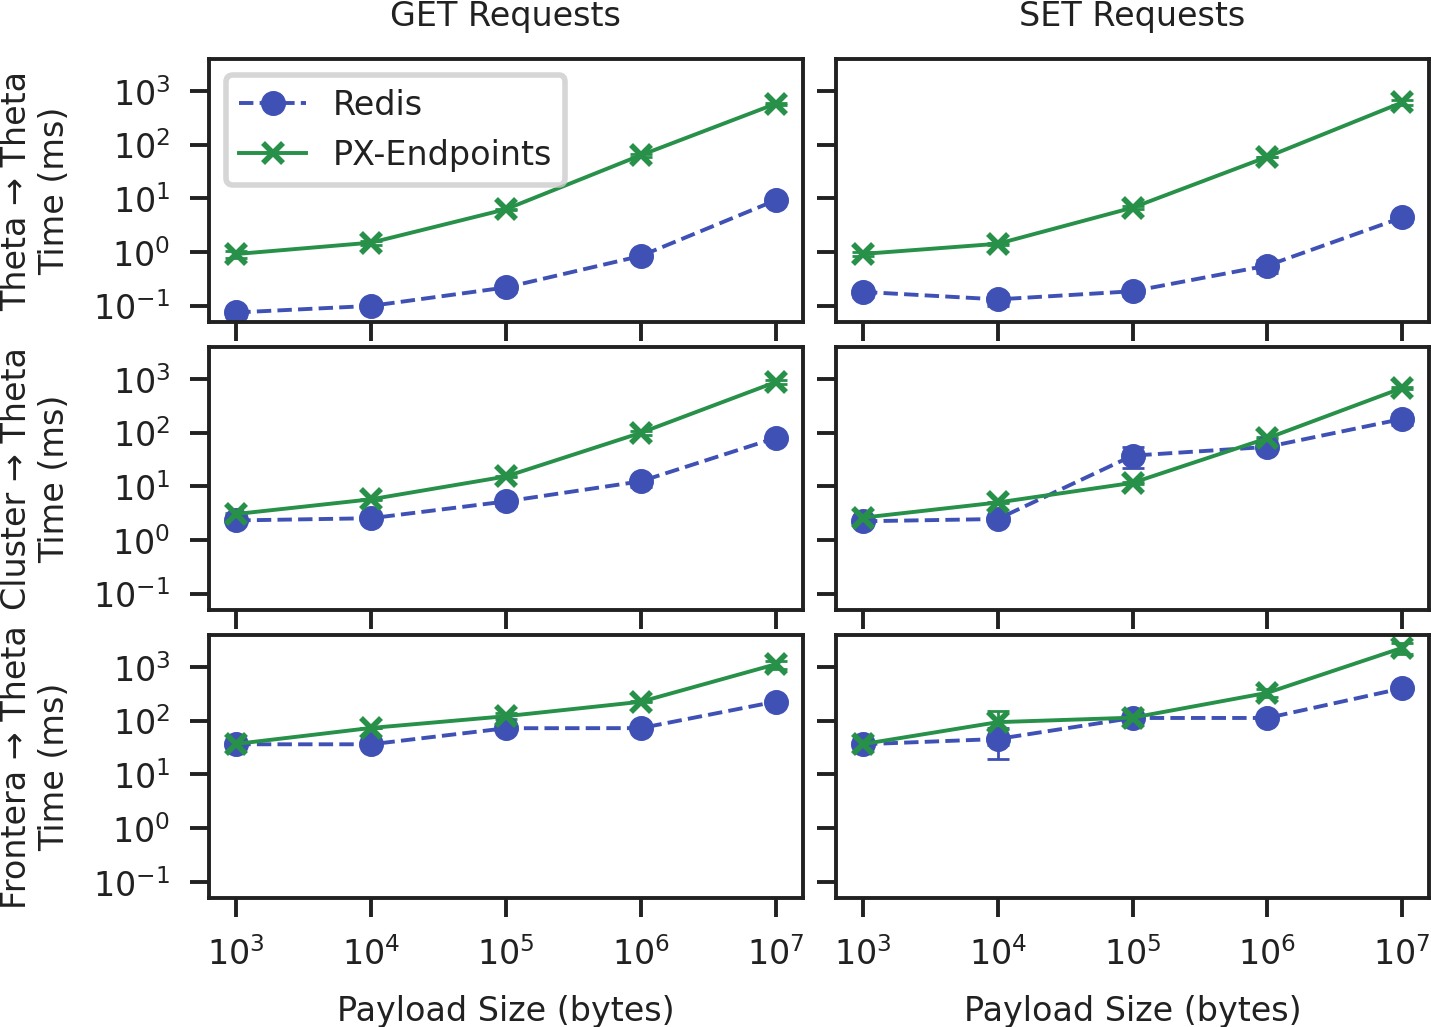

In [33]:
MARKERS = ('o', 'x')
LINES = ('--', '-')

payload_labels = ['1 KB', '10 KB', '100 KB', '1 MB', '10 MB']

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)

for i, (systems, data) in enumerate(DATA.items()):

    for j, op in enumerate(('GET', 'SET')):
        ax = axs[i, j]
        ax.set_yscale('log', base=10)
        ax.set_xscale('log', base=10)
        ax.set_xticks([1e3, 1e4, 1e5, 1e6, 1e7])
    
        op_data = rows_matching_column_value(data, OP_COLUMN, op)
        endpoint_data = rows_matching_column_value(op_data, BACKEND_COLUMN, 'ENDPOINT')
        redis_data = rows_matching_column_value(op_data, BACKEND_COLUMN, 'REDIS')
    
        for k, (name, series) in enumerate((('Redis', redis_data), (ENDPOINTS_NAME, endpoint_data))):
            ax.errorbar(
                series[PAYLOAD_COLUMN],
                series[AVG_TIME_COLUMN],
                # yerr=numpy.stack([series[MIN_TIME_COLUMN], series[MAX_TIME_COLUMN]]),
                yerr=series[STDEV_TIME_COLUMN],
                marker=MARKERS[k],
                label=f'{name}',
                linestyle=LINES[k],
                capsize=2,
                elinewidth=0.5,
                capthick=0.5,
            )


# fig.suptitle('Endpoint to Endpoint Request Time')
for i, systems in enumerate(DATA):
    systems = systems if not systems.startswith('Campus') else systems.replace('Campus ', '')
    axs[i, 0].set_ylabel(f'{systems}\nTime (ms)', fontsize=6)
axs[0, 0].set_title('GET Requests')
axs[0, 1].set_title('SET Requests')
axs[-1, 0].set_xlabel('Payload Size (bytes)')
axs[-1, 1].set_xlabel('Payload Size (bytes)')

# Use integer x labels instead of powers of 2
plt.yticks([0.01, 0.1, 1, 10, 100, 1000])
plt.ylim([0.05, 4000])
plt.minorticks_off()

# get handles
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
axs[0, 0].legend(handles, labels, loc='upper left')

fig.tight_layout(h_pad=.5, w_pad=0.75)

fig.set_size_inches(3.5, 2.5)
plt.savefig('figures/endpoint-times-remote.pdf', pad_inches=0.05)